In [15]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from tqdm import tqdm
%matplotlib inline

In [2]:
# https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [3]:
SOYBEANS = 'Soybeans(CBOT)'

In [4]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
mrci_eod_filter = os.path.join('data', '*.csv')
mrci_eod_files = glob.glob(mrci_eod_filter)

In [6]:
converters = {'month': lambda d: pd.to_datetime(d.replace('\r\n', ''), format='%b%y'),
              'date': lambda d: pd.to_datetime(d, format='%y%m%d'),
           }

In [8]:
col_names = ['future_name', 'month', 'date', 'open', 'high', 'low', 'close'] # 'close_change', 'volume', 'open_int', 'open_int_change']
futures_all = pd.concat((pd.read_csv(f, 
                                     usecols=[1, 2, 3, 4, 5, 6, 7],
                                     header=1,
                                     names=col_names,
                                     converters=converters,
                                    )
                                    for f in mrci_eod_files),
                       ignore_index=True)

In [9]:
futures_all.date.max()

Timestamp('2019-09-05 00:00:00')

In [10]:
futures_all.drop_duplicates(inplace=True)
futures_all.replace('~','.', inplace=True, regex=True)
#futures_all.replace('unch', 0, inplace=True, regex=True)

In [11]:
futures_all.loc[:, 'open':] = futures_all.loc[:, 'open':].applymap(np.double)

In [12]:
soybeans = futures_all.loc[futures_all.future_name == SOYBEANS]

In [13]:
soybeans.date.max()

Timestamp('2019-09-05 00:00:00')

In [14]:
soybeans_front_month = soybeans.loc[soybeans.groupby('date')['month'].idxmin()]

In [15]:
soybeans_front_month.sort_values(by='date', inplace=True)

In [16]:
soybeans_front_month.set_index('date', inplace=True)

In [40]:
soybeans_front_month = soybeans_front_month.asfreq('B').fillna(method='ffill')

In [41]:
soybeans_front_month.tail()

,future_name,month,open,high,low,close,month_diff,close_diff
date,,,,,,,,
2019-08-30,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.5
2019-09-02,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.0
2019-09-03,Soybeans(CBOT),2019-11-01,866.25,869.25,859.25,868.5,0.0,-0.5
2019-09-04,Soybeans(CBOT),2019-11-01,867.25,879.50,864.25,875.5,0.0,7.0
2019-09-05,Soybeans(CBOT),2019-11-01,875.25,878.75,858.25,861.5,0.0,-14.0


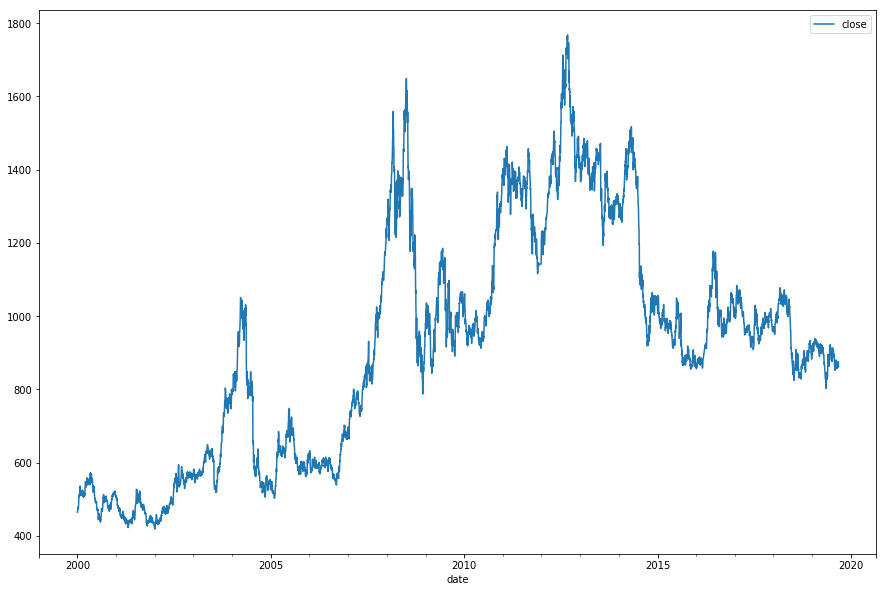

In [26]:
soybeans_front_month.plot.line(y='close', 
                               figsize=(15, 10), 
                               #xlim=('2014-09-05', '2019-09-05'),
                              );

In [42]:
soybeans_front_month['month_diff'] = soybeans_front_month.month.diff(1).dt.days

In [43]:
soybeans_front_month['close_diff'] =  soybeans_front_month.close.diff(1)

In [29]:
# Remove contract roll dates.
#soybeans_front_month = soybeans_front_month.loc[soybeans_front_month.month_diff == 0]

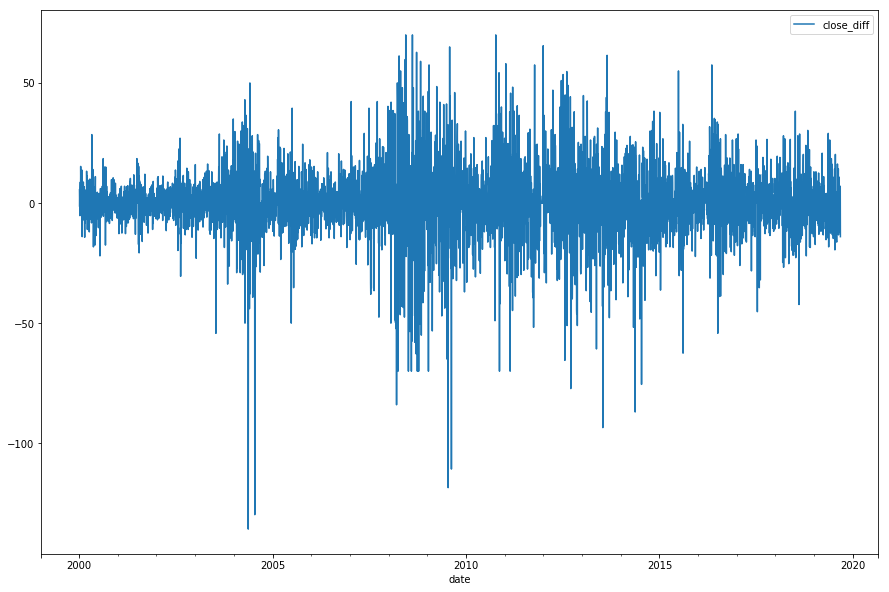

In [44]:
soybeans_front_month.plot.line(y='close_diff', figsize=(15, 10));

<Figure size 432x288 with 0 Axes>

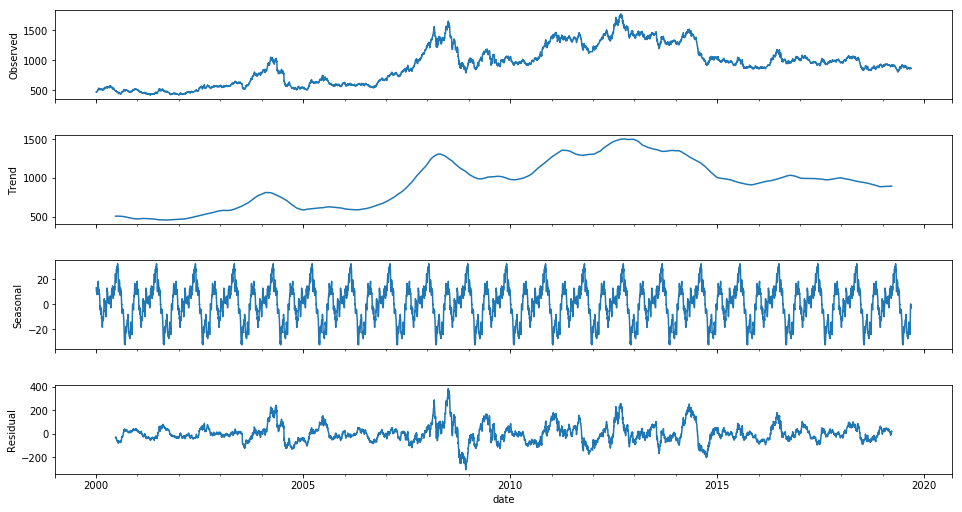

In [45]:
decomposition = seasonal_decompose(soybeans_front_month.close, freq=245)
fig = plt.figure()
fig = decomposition.plot();
fig.set_size_inches(15, 8)

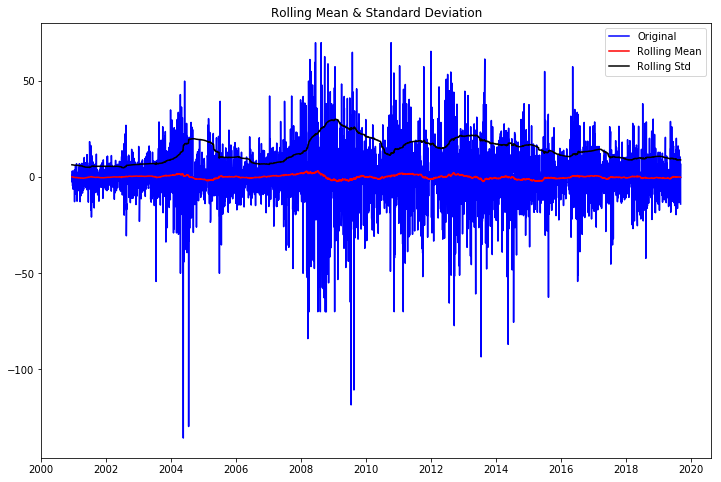

Results of Dickey-Fuller Test:
Test Statistic                  -20.250640
p-value                           0.000000
#Lags Used                       10.000000
Number of Observations Used    5121.000000
Critical Value (1%)              -3.431628
Critical Value (5%)              -2.862105
Critical Value (10%)             -2.567071
dtype: float64


In [49]:
test_stationarity(soybeans_front_month.close_diff[1:], 245)

(0, 0.2)

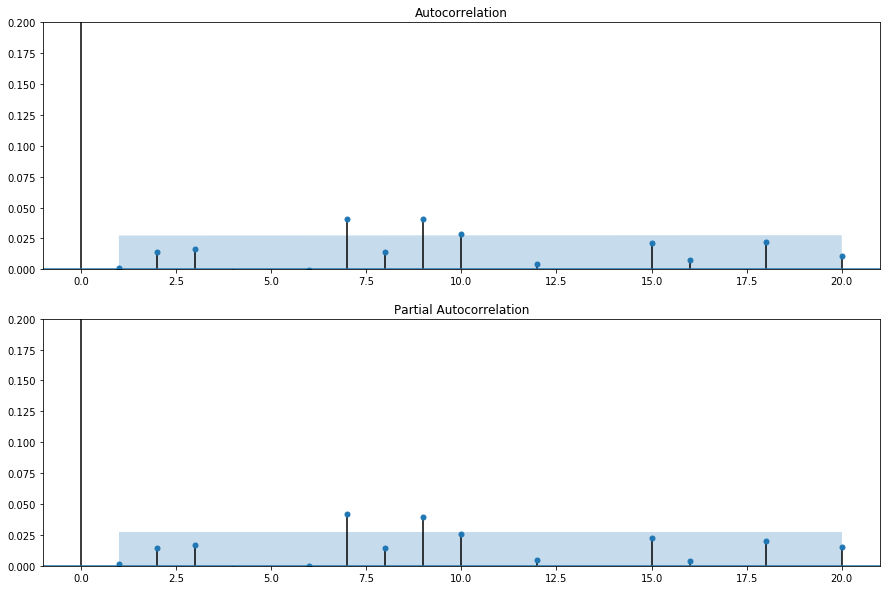

In [50]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_front_month.close_diff.dropna(), lags=20, ax=ax1)
plt.ylim(0, 0.2)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_front_month.close_diff.dropna(), lags=20, ax=ax2)
plt.ylim(0, 0.2)

In [115]:
soybeans_front_month['seasonal_diff'] = soybeans_front_month.close.diff(260)

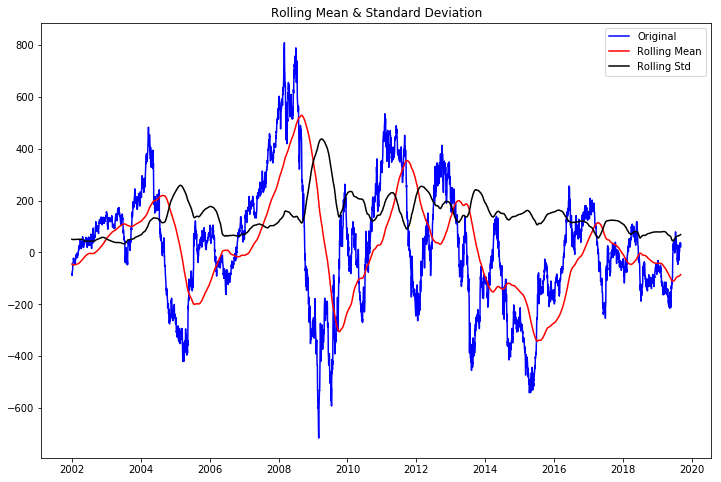

Results of Dickey-Fuller Test:
Test Statistic                   -3.568851
p-value                           0.006385
#Lags Used                       18.000000
Number of Observations Used    4854.000000
Critical Value (1%)              -3.431698
Critical Value (5%)              -2.862136
Critical Value (10%)             -2.567087
dtype: float64


In [118]:
test_stationarity(soybeans_front_month.seasonal_diff.dropna(), 260)

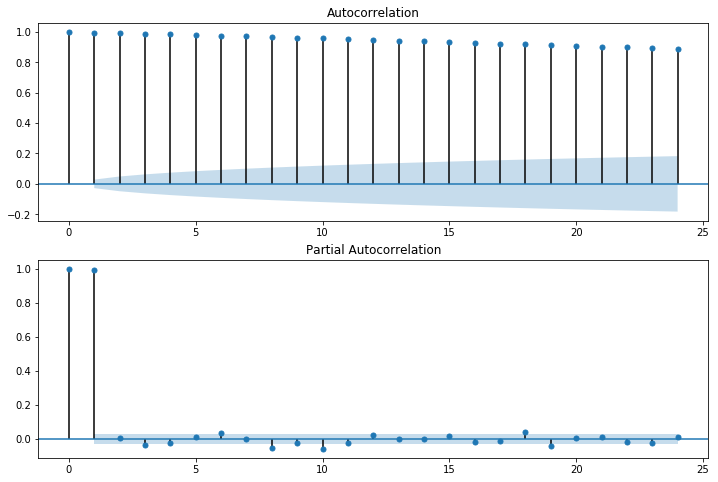

In [116]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_front_month.seasonal_diff.dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_front_month.seasonal_diff.dropna(), lags=24, ax=ax2)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(
    soybeans_front_month.loc[:'2018-1-1'].close,
    trend='n',
    order=(7,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False,
    #seasonal_order=(0,1,1,260),
    seasonal_order=(7,1,7,52),
    freq='B',
)
res = mod.fit()
res.summary()

In [149]:
prediction = res.predict(start=4495, end=4694, dynamic=False)
prediction.head()

date
2017-03-28    978.891517
2017-03-29    982.282271
2017-03-30    978.287141
2017-03-31    971.702307
2017-04-03    957.105353
Freq: B, dtype: float64

In [150]:
soybeans_front_month['forecast'] = prediction

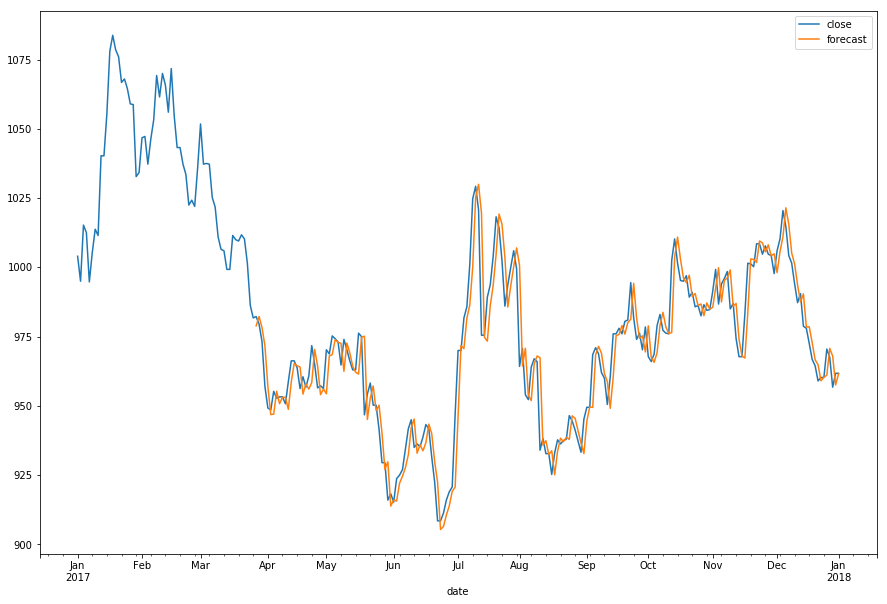

In [151]:
#plt.plot(soybeans_front_month.close, figsize=(15, 10))
#plt.plot(prediction, figsize=(15, 10))
soybeans_front_month.loc['2017-1-1': '2018-1-1', ['close', 'forecast']].plot(figsize=(15, 10))

In [152]:
soybeans_front_month.shape

(5133, 10)

In [153]:
soybeans_front_month['forecast'] = res.predict(start=4694, end=5132, dynamic=True) # all
#soybeans_front_month['forecast'] = res.predict(start=783, end=900, dynamic=True) 

In [154]:
soybeans_front_month.tail()

,future_name,month,open,high,low,close,month_diff,close_diff,forecast,seasonal_diff
date,,,,,,,,,,
2019-08-30,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.5,665.693062,25.50
2019-09-02,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.0,665.000594,25.50
2019-09-03,Soybeans(CBOT),2019-11-01,866.25,869.25,859.25,868.5,0.0,-0.5,664.308126,24.25
2019-09-04,Soybeans(CBOT),2019-11-01,867.25,879.50,864.25,875.5,0.0,7.0,663.615659,37.50
2019-09-05,Soybeans(CBOT),2019-11-01,875.25,878.75,858.25,861.5,0.0,-14.0,662.923191,22.25


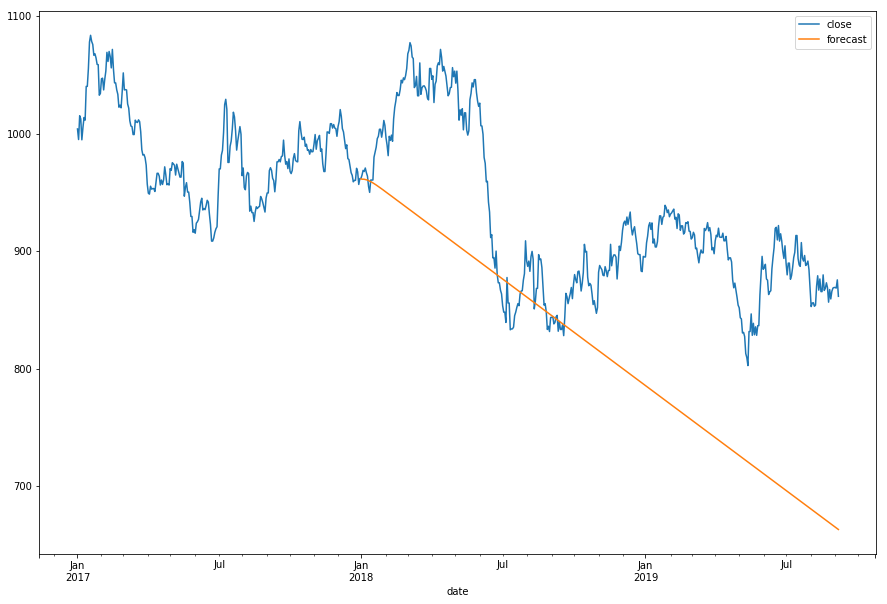

In [155]:
soybeans_front_month.dropna(subset=['close']).loc['2017-1-1':, ['close', 'forecast']].plot(figsize=(15, 10))

In [162]:
soybeans_front_month.tail()

,future_name,month,open,high,low,close,month_diff,close_diff,forecast,seasonal_diff
date,,,,,,,,,,
2019-08-30,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.5,665.693062,25.50
2019-09-02,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.0,665.000594,25.50
2019-09-03,Soybeans(CBOT),2019-11-01,866.25,869.25,859.25,868.5,0.0,-0.5,664.308126,24.25
2019-09-04,Soybeans(CBOT),2019-11-01,867.25,879.50,864.25,875.5,0.0,7.0,663.615659,37.50
2019-09-05,Soybeans(CBOT),2019-11-01,875.25,878.75,858.25,861.5,0.0,-14.0,662.923191,22.25


In [163]:
#soybeans_front_month.to_pickle('./clean_data/soybeans_front_month.pkl')

In [165]:
pwd

'/Users/flatironschool/Documents/personal_projects/mrci_data'

In [7]:
soybeans_front_month = pd.read_pickle('clean_data/soybeans_front_month.pkl')

In [8]:
#soybeans_front_month['monthly_average'] 
soybeans_monthly_average =  soybeans_front_month.close.resample('m').mean()

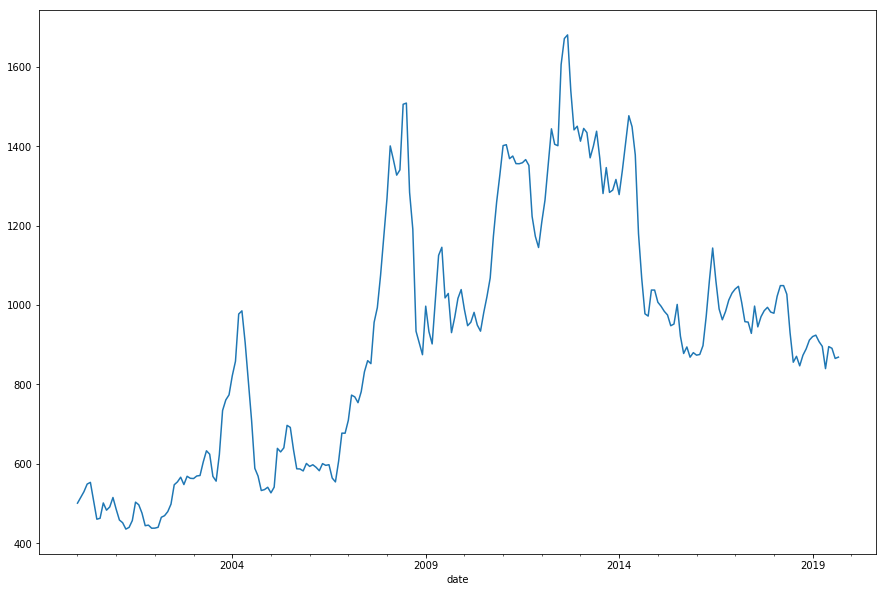

In [9]:
soybeans_monthly_average.plot(figsize=(15, 10))

<Figure size 432x288 with 0 Axes>

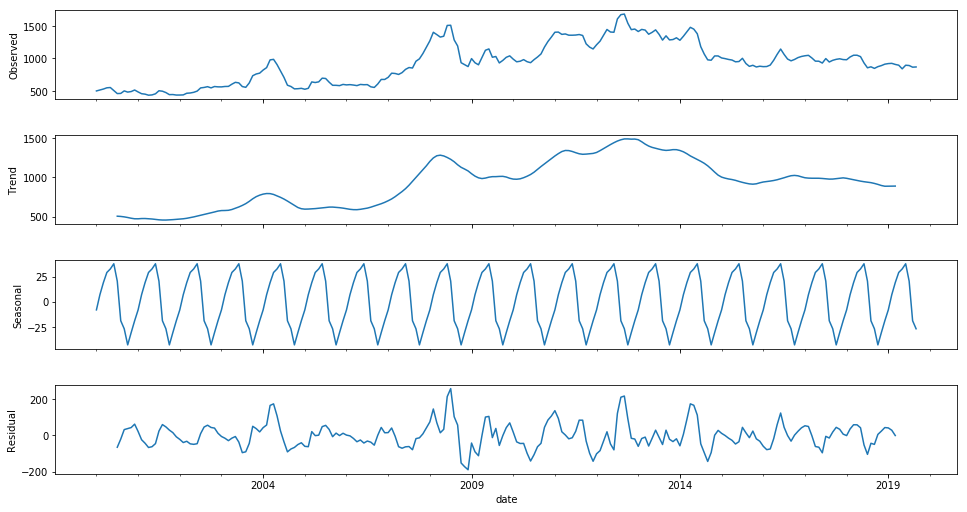

In [10]:
decomposition = seasonal_decompose(soybeans_monthly_average, freq=12)
fig = plt.figure()
fig = decomposition.plot();
fig.set_size_inches(15, 8)

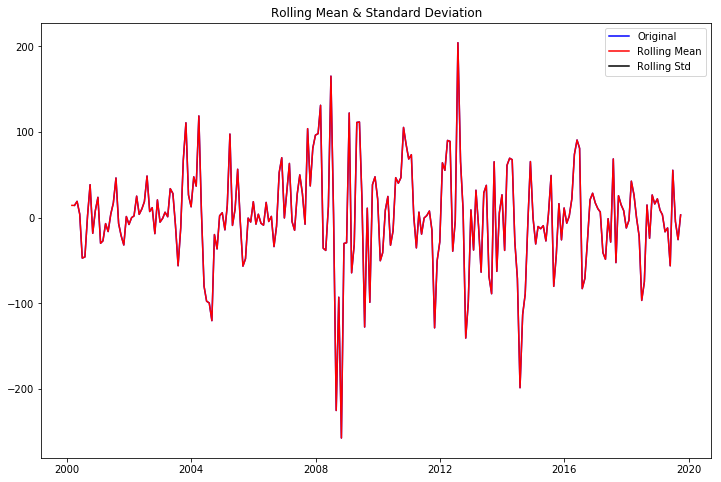

Results of Dickey-Fuller Test:
Test Statistic                -6.814090e+00
p-value                        2.080439e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


In [11]:
test_stationarity(soybeans_monthly_average.diff(1).dropna(), 1)

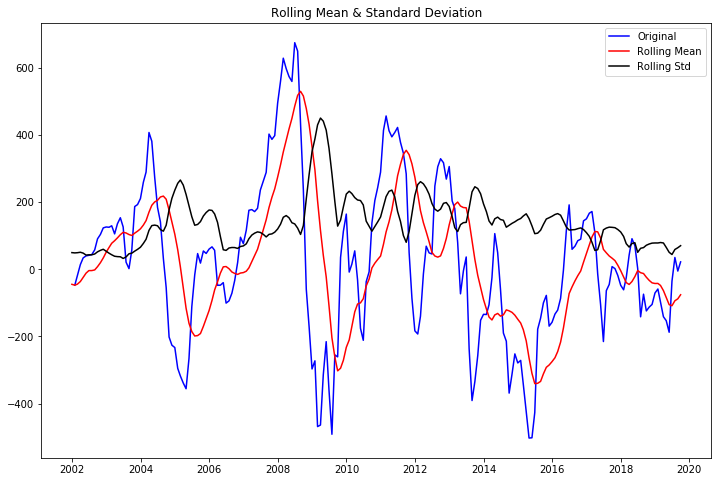

Results of Dickey-Fuller Test:
Test Statistic                  -3.038917
p-value                          0.031416
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


In [12]:
test_stationarity(soybeans_monthly_average.diff(12).dropna(), 12)

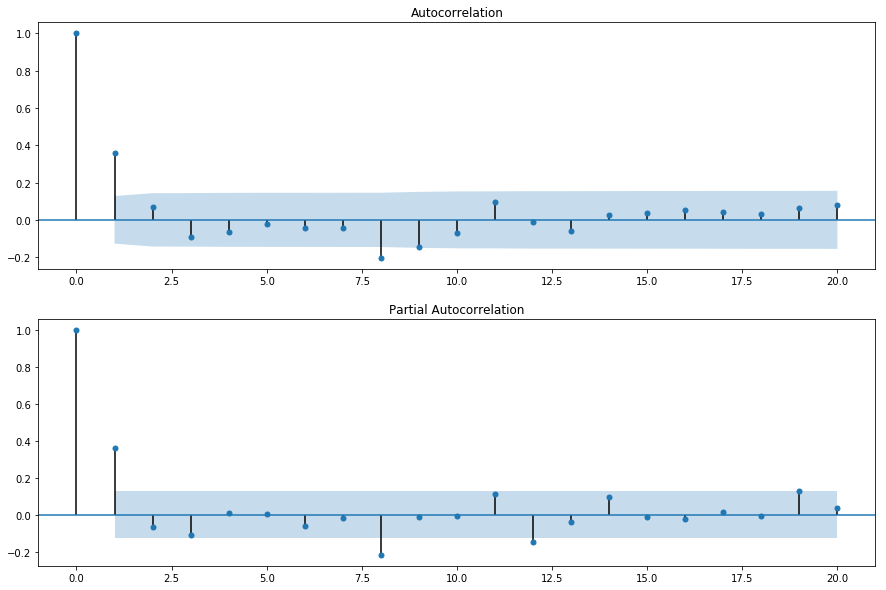

In [13]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_monthly_average.diff(1).dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_monthly_average.diff(1).dropna(), lags=20, ax=ax2)

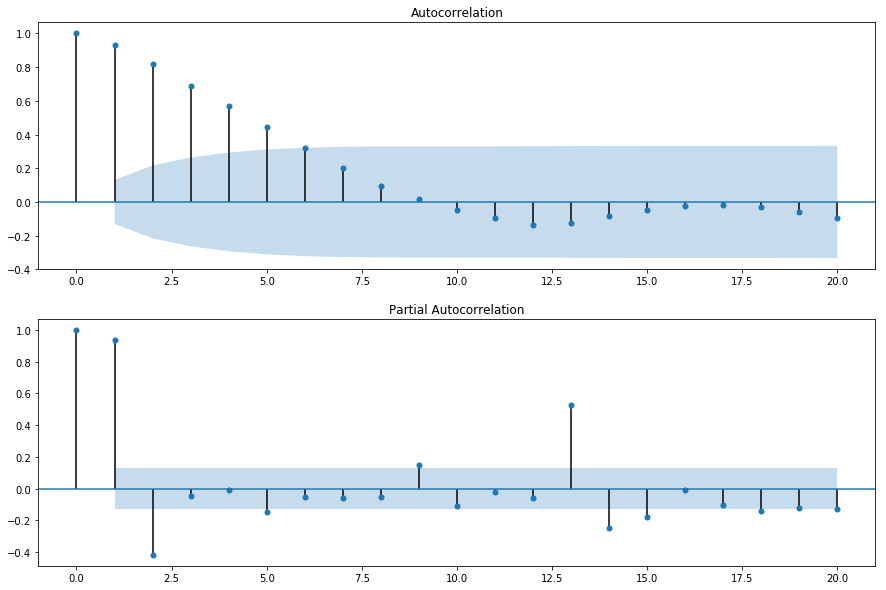

In [14]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_monthly_average.diff(12).dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_monthly_average.diff(12).dropna(), lags=20, ax=ax2)

In [ ]:
test_results = []
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(soybeans_monthly_average.loc[:'2018-9-1'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            result_string = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
            test_results.append([result_string, results.aic])
            
        except Exception as e:
            print('exception in:', pdq, seasonal_pdq)
            print(e)
            continue

In [16]:
results_df = pd.DataFrame(test_results, columns=['key', 'aic'])

NameError: name 'test_results' is not defined

In [ ]:
results_df.loc[results_df.aic.idxmin()]

In [73]:
mod = sm.tsa.statespace.SARIMAX(
    soybeans_monthly_average.loc[:'2018-9-1'],
    trend='t',
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False,
    seasonal_order=(5, 1, 1, 12),
    freq='M',
)
res = mod.fit()
res.summary()

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  224
Model:             SARIMAX(1, 0, 1)x(5, 1, 1, 12)   Log Likelihood                -840.089
Date:                            Mon, 09 Sep 2019   AIC                           1700.177
Time:                                    16:39:45   BIC                           1730.350
Sample:                                01-31-2000   HQIC                          1712.435
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0072      0.017     -0.434      0.664      -0.040       0.025
ar.L1          0.9886      0.017     58.197      0.000       0.955       1.022
ma.L1          0.3248      0.087      3.727      0.000       0.154       0.496
ar.S.L12      -0.1812      0.094     -1.920      0.055      -0.366       0.004
ar.S.L24      -0.2832      0.088     -3.236      0.001      -0.455      -0.112
ar.S.L36      -0.1706      0.101     -1.682      0.093      -0.369       0.028
ar.S.L48      -0.1466      0.082     -1.783      0.075      -0.308       0.015
ar.S.L60      -0.0344      0.080     -0.429      0.668      -0.191       0.123
ma.S.L12      -1.0000      0.092    -10.905      0.000      -1.180      -0.820
sigma2      3383.5640   2.71e-05   1.25e+08      0.000    3383.564    3383.564
===================================================================================
Ljung-Box (Q):                       41.50   Jarque-Bera (JB):                19.54
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+23. Standard errors may be unstable.
"""

In [74]:
prediction = res.predict(200, 223+24)

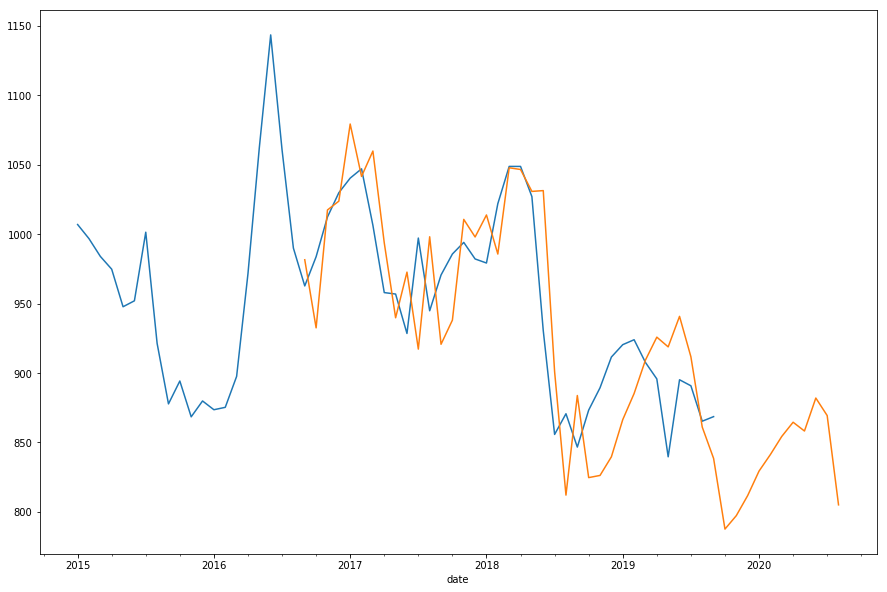

In [75]:
soybeans_monthly_average.loc['2015-1-1':].plot(figsize=(15, 10))
prediction.plot(figsize=(15, 10))

In [77]:
res.conf_int()

,0,1
drift,-0.039960,0.025471
ar.L1,0.955312,1.021900
ma.L1,0.153989,0.495595
ar.S.L12,-0.366195,0.003801
ar.S.L24,-0.454697,-0.111634
ar.S.L36,-0.369419,0.028197
ar.S.L48,-0.307689,0.014560
ar.S.L60,-0.191334,0.122583
ma.S.L12,-1.179743,-0.820265
sigma2,3383.563927,3383.564034
